In [ ]:
from io import BytesIO
from PIL import Image
from typing import List, Tuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation

from umap import UMAP

splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])


In [11]:
def get_image_features(bytes: str) -> np.ndarray:
    image = Image.open(BytesIO(bytes))
    return np.array(image).flatten()  

In [ ]:
data = np.array([get_image_features(bytes["bytes"]) for bytes in df["image"]])


In [13]:
umap = UMAP()

embedding = umap.fit_transform(data)

/Users/dmitry057/Projects/DeepL/archi-ve/FreeCAD/.conda/ml/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
def save_embedding_animation(
    embedding_history: List[np.ndarray],
    y: np.ndarray,
    output_file: str,
):
    all_points = np.concatenate(embedding_history)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])

    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05

    fig, ax = plt.subplots()
    ax.axis("off")
    
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

    sc = ax.scatter(
        embedding_history[0][:, 0], embedding_history[0][:, 1], c=y, cmap="tab10"
    )

    def update(frame):
        sc.set_offsets(embedding_history[frame])
        return [sc]

    ani = animation.FuncAnimation(
        fig, update, frames=len(embedding_history), interval=50, blit=True
    )

    writer = animation.FFMpegWriter(fps=20)
    ani.save(output_file, writer=writer)
    plt.close(fig)
    print(f"Animation saved to {output_file}")

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../public/umap_animation.mp4']' returned non-zero exit status 255.

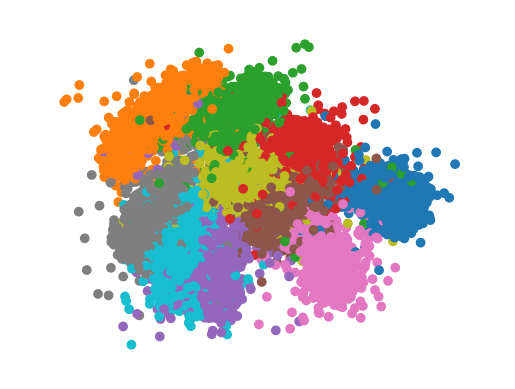

In [ ]:

def emb2anim(
    embedding_history: List[np.ndarray],
    y: np.ndarray
):
    list_of_frames: List[List[Tuple[float,float,float]]] = []
    for frame in embedding_history:
        list_of_frames.append([(point[0], point[1], point[2]) for point in frame])
    labels = [int(y_item) for y_item in y]
    
    if(len(list_of_frames) == 0):
        raise ValueError("No frames found in the embedding history")
    
    if(len(labels) != len(list_of_frames[0])):
        raise ValueError("Length of labels must match the number of frames")
    
    animation = {
        "frames":list_of_frames,
        "labels":labels
    }
    
    return animation

save_embedding_animation(umap.embedding_hist, df["label"], "../public/umap_animation.mp4")

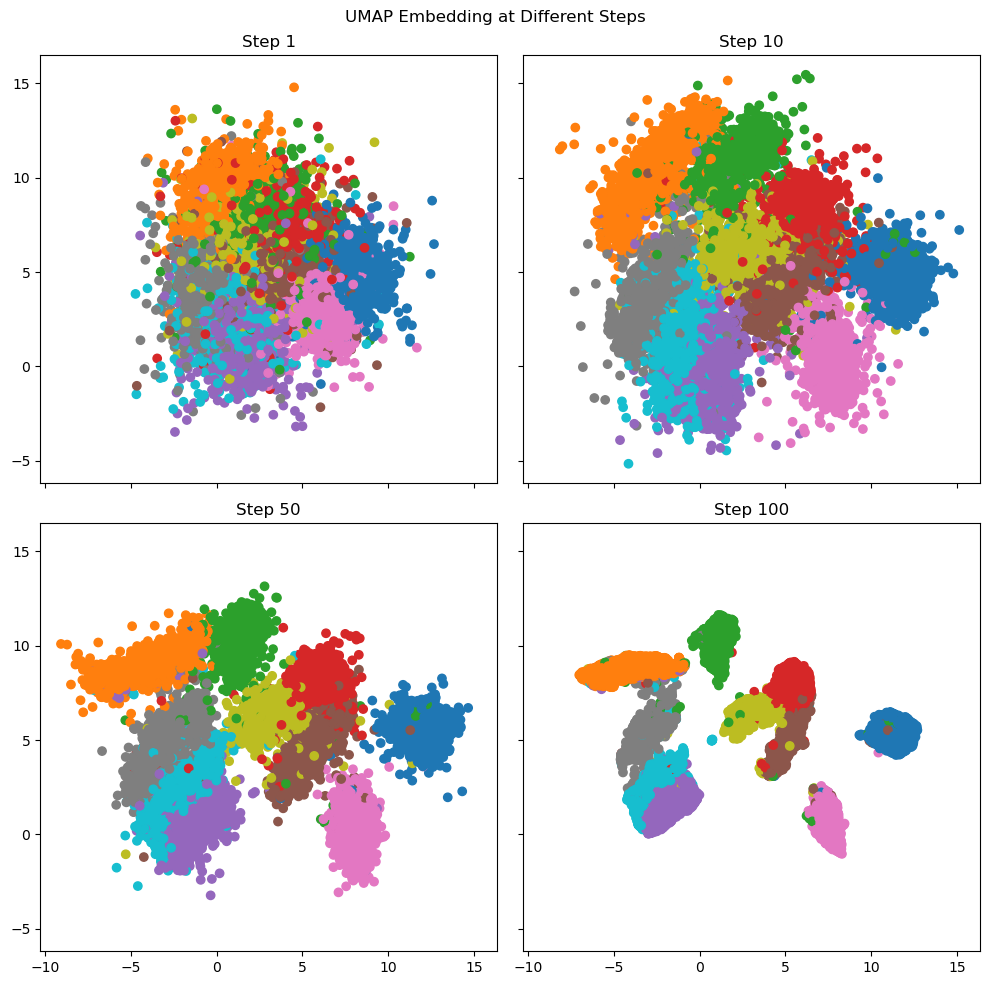

In [15]:
frame_ids = [0, 9, len(umap.embedding_hist) // 2 - 1, len(umap.embedding_hist) - 1]
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
axs = axs.flatten()
fig.suptitle("UMAP Embedding at Different Steps")

for ax, frame_id in zip(axs, frame_ids):
    ax.scatter(umap.embedding_hist[frame_id][:, 0], umap.embedding_hist[frame_id][:, 1], c=df["label"], cmap="tab10")
    ax.set_title(f"Step {frame_id + 1}")

plt.tight_layout()
plt.savefig("../public/umap_steps.png")
plt.show()